# Basic Neural Nets with Backpropagation from scratch

This notebook shows how to implement neural nets from scratch to do multi-class classification of digits!

![Handwritten digits grid](notebooks/nnets-files/handwritten_digits.png?raw=true "Handwritten digits grid")

You can find this code in modules [here](https://github.com/arturomp/coursera-machine-learning-in-python/tree/master/mlclass-ex4-004/mlclass-ex4), along with the files used.

This code was ported from Octave/Matlab to python and was part of the absolutely excellent [Machine Learning course](http://ml-class.org) by Stanford's [Andrew Ng](http://www.andrewng.org) on Coursera.

---

We first import the appropriate libraries:

In [126]:
import scipy.io
import numpy as np
from scipy.optimize import minimize
import math
import matplotlib.pyplot as plt
from scipy.special import expit 
from decimal import Decimal

Then set up the parameters for the simple neural net:

In [127]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

We'll have an architecture with three layers: the input layer (the training data), a hidden layer (which learns its own feature representations), and an output data (the labels). This is a rough illustration of our neural net:

![Neural nets architecture with equations.png](notebooks/nnets-files/neural-net-architecture-equations.png?raw=true "Neural nets architecture with equations")

## Visualization

We can visualize 100 random data points (out of the 5,000 in the data set) with the [``displayData()``](https://github.com/arturomp/coursera-machine-learning-in-python/blob/master/mlclass-ex4-004/mlclass-ex4/displayData.py) function. If you look at [the full code files](https://github.com/arturomp/coursera-machine-learning-in-python/blob/master/mlclass-ex4-004/mlclass-ex4/displayData.py), you can see more comments on many lines' particular functions, for this or any section going forward. 

I found that applying ``flatten()`` to the labels ``y`` is crucial in getting good performance - otherwise the minimization isn't very effective. What it does is change the dimension of the labels from ``(m,1)`` to ``(m,)``, which in ``numpy`` can have significantly different behaviours in different functions.

In [ ]:
def displayData(X, example_width=None):

    plt.close()
    plt.figure(figsize=(10, 10))
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))

    plt.set_cmap("gray")

    m, n = X.shape
    example_height = n / example_width

    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))

    pad = 1

    display_array = -np.ones((pad + display_rows * (example_height + pad),  \
                              pad + display_cols * (example_width + pad)))

    curr_ex = 1
    for j in xrange(1,display_rows+1):
        for i in xrange (1,display_cols+1):
            if curr_ex > m:
                break
        
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (example_height + pad) + np.array(range(example_height))
            cols = pad + (i - 1) * (example_width  + pad) + np.array(range(example_width ))

            # Basic (vs. advanced) indexing/slicing is necessary so that we look can assign
            #   values directly to display_array and not to a copy of its subarray.
            # Also notice the order="F" parameter on the reshape call
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = \
                        np.reshape(X[curr_ex-1, :], (example_height, example_width), order="F") / max_val
            curr_ex += 1
    
        if curr_ex > m:
            break

    h = plt.imshow(display_array, vmin=-1, vmax=1)

    plt.axis('off')

    plt.show(block=False)

    return h, display_array    

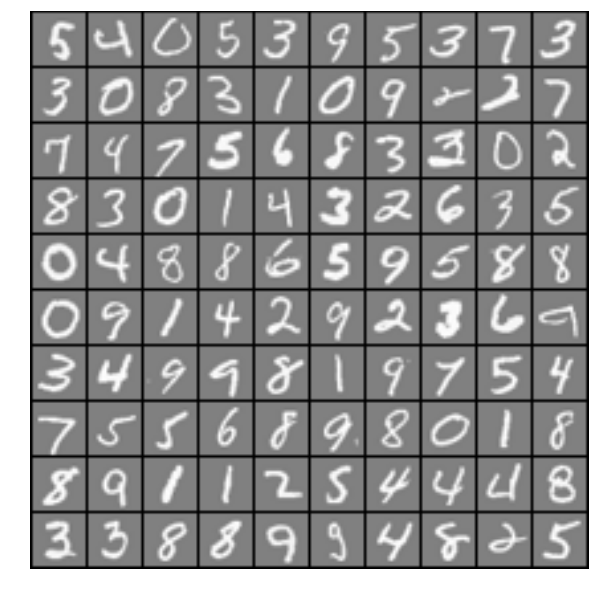

In [144]:
mat = scipy.io.loadmat('notebooks/nnets-files/ex4data1.mat')
X = mat["X"]
y = mat["y"]
y=y.flatten() 

m = X.shape[0]

rand_indices = np.random.permutation(m)
sel = X[rand_indices[:100],:]

_, _ = displayData(sel)

## Cost function

Now we load some pretrained weights to easily implement the first few parts of the network:

In [129]:
mat = scipy.io.loadmat('notebooks/nnets-files/ex4weights.mat')
Theta1 = mat["Theta1"]
Theta2 = mat["Theta2"]

And we unroll these parameters:

In [130]:
nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))

As a first step of the neural net, we implement the feedforward component that only returns the cost.

In [131]:
def sigmoid(z):
    """Computes the sigmoid of z.
    """
    g = np.zeros(z.shape)
    g = expit(z)
    return g

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
    num_labels, X, y, lambda_reg):
    """Implements the neural network cost function for a two layer
    neural network which performs classification
    """
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')

    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    labels = y    
    y = np.zeros((m,num_labels))
    
    for i in xrange(m):
        y[i, labels[i]-1] = 1
        
    cost = 0
    for i in xrange(m):
        cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )

    J = -(1.0/m)*cost

    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), 
                           Theta2_grad.reshape(Theta2_grad.size, order='F')))

    return J, grad

And we test the ``nnCostFunction()`` function to ensure we get the expected value of 0.287629:

In [132]:
lambda_reg = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
                   num_labels, X, y, lambda_reg)

print('Training Set Accuracy: {:f}'.format(J))

Training Set Accuracy: 0.287629


## Regularization

Now, to the cost function above, we add regularization. Regularization helps prevent overfitting! We now expect a cost, again using the pretrained weights, of 0.383770.

In [ ]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
    num_labels, X, y, lambda_reg):
    """Implements the neural network cost function with regularization
    for a two layer neural network which performs classification
    """
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')

    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    labels = y    
    y = np.zeros((m,num_labels))
    
    # one-hot encoding
    for i in xrange(m):
        y[i, labels[i]-1] = 1
        
    cost = 0
    for i in xrange(m):
        cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )

    J = -(1.0/m)*cost
    
    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))

    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )

    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), 
                           Theta2_grad.reshape(Theta2_grad.size, order='F')))

    return J, grad

In [133]:
lambda_reg = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
                   num_labels, X, y, lambda_reg)

print('Cost at parameters (loaded from ex4weights): {:f}'.format(J))

Cost at parameters (loaded from ex4weights): 0.383770


## Backpropagation

The backpropagation algorithm is on of the main reasons why neural networks are so powerful- by backpropagating the error from the output layer back to the hidden layer(s), a neural net learns its own features and can create better representations of the data than manual feature engineering can.

We start with defining and demonstrating a function to calculate the sigmoid gradient:

In [134]:
def sigmoidGradient(z):
    """Returns the gradient of the sigmoid function evaluated at z
    """
    g = 1.0 / (1.0 + np.exp(-z))
    g = g*(1-g)
    return g

g = sigmoidGradient( np.array([1, -0.5, 0, 0.5, 1]) )
print('Sigmoid gradient evaluated at [1, -0.5, 0, 0.5, 1]:')
print('{:s}\n'.format(g))

Sigmoid gradient evaluated at [1, -0.5, 0, 0.5, 1]:
[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]



An important part of a neural network with our architecture is "symmetry breaking": a random intialization of the weights. Otherwise, all the weights are modified in exactly the same way, which leads to very little learning. The function ``randInitializeWeights()`` serves this purpose:

In [ ]:
def randInitializeWeights(L_in, L_out):
    """Randomly initialize the weights of a layer with L_in
    incoming connections and L_out outgoing connections
    """
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in)*(2*epsilon_init) - epsilon_init
    return W

In [135]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate((initial_Theta1.reshape(initial_Theta1.size, order='F'), 
                                    initial_Theta2.reshape(initial_Theta2.size, order='F')))

Now we implement the backpropagation algorithm. Backpropagation happens after the feedforward pass where, with our initial random weights, a cost is calculated. The backpropagation of this cost means that for each node in each layer, we can measure how much that node contributed to the error, or cost, from the forward pass.

![Neural nets architecture with equations.png](notebooks/nnets-files/backprop.png?raw=true "Backpropagation architecture with equations")

To implement this we build on our ``nnCostFunctionX()`` function by adding proper calculations for the ``grad`` return values

In [136]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
    num_labels, X, y, lambda_reg):
    """Implements the neural network cost function with regularization
    plus backpropagation for a two layer neural network which 
    performs classification
    """
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')

    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    labels = y    
    y = np.zeros((m,num_labels))
    
    # one-hot encoding
    for i in xrange(m):
        y[i, labels[i]-1] = 1
        
    cost = 0
    for i in xrange(m):
        cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )

    J = -(1.0/m)*cost
    
    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))

    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )

    bigDelta1 = 0
    bigDelta2 = 0
    
    # iterate over training examples
    for t in xrange(m):
        ## forward pass
        # t-th row of X
        x = X[t]
        
        # sigmoid( z2 ) where z2 = Theta1 * a1
        a2 = sigmoid( np.dot(x,Theta1.T) )

        # bias unit
        a2 = np.concatenate((np.array([1]), a2))
        # sigmoid ( z3 ) where z3 = Theta2 * a2
        a3 = sigmoid( np.dot(a2,Theta2.T) )

        ## for each output unit k in layer 3, set delta_{k}^{(3)}
        delta3 = np.zeros((num_labels))

        # whether current training example belongs to class k (y_k = 1), 
        # or if it belongs to a different class (y_k = 0)
        for k in xrange(num_labels):
            y_k = y[t, k]
            delta3[k] = a3[k] - y_k

        ## delta2 = Theta2' * delta3 .* sigmoidGradient(z2), skipping bias unit gradients
        delta2 = (np.dot(Theta2[:,1:].T, delta3).T) * sigmoidGradient( np.dot(x, Theta1.T) )

        ## step 4: accumulate gradient from this example
        bigDelta1 += np.outer(delta2, x)
        bigDelta2 += np.outer(delta3, a2)

    # step 5: obtain gradient for neural net cost function by dividing the accumulated gradients by m
    Theta1_grad = bigDelta1 / m
    Theta2_grad = bigDelta2 / m

    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), 
                           Theta2_grad.reshape(Theta2_grad.size, order='F')))

    return J, grad

It's easy to get backpropagation details wrong. To verify that it's properly implemented, we do gradient checking. This is a numerical verification layer that serves to verify any function that computes a cost and a gradient.

Note that ``checkNNGradients()`` actually creates a small neural network with a small number of input and hidden units that keeps the number of parameters low. This is because calculating the numerical gradients can be expensive, and the only purpose of running this function with a mock neural is to ensure the cost function is doing backprop properly.

In [ ]:
def debugInitializeWeights(fan_out, fan_in):
    """Initialize the weights of a layer with fan_in
    incoming connections and fan_out outgoing connections using a fixed
    strategy
    """
    W = np.zeros((fan_out, 1 + fan_in))
    W = np.reshape(np.sin(range(W.size)), W.shape) / 10

    return W

def computeNumericalGradient(J, theta):
    """Computes the the numerical gradient of the function J 
    around theta using 'finite differences'.
    Returns a numerical estimate of the gradient.
    """

    numgrad = np.zeros( theta.shape )
    perturb = np.zeros( theta.shape )
    e = 1e-4

    for p in xrange(theta.size):
        # Set perturbation vector
        perturb.reshape(perturb.size, order="F")[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        # Compute Numerical Gradient
        numgrad.reshape(numgrad.size, order="F")[p] = (loss2 - loss1) / (2*e)
        perturb.reshape(perturb.size, order="F")[p] = 0

    return numgrad

def checkNNGradients(lambda_reg=0):
    """Creates a small neural network to check the backpropagation gradients.
    Return  the analytical gradients produced by the backprop code in the 
    cost function and the numerical gradients.
    These two gradient computations should result in very similar values.
    """

    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    # generate X
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y  = 1 + np.mod(range(m), num_labels).T

    nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))

    # Shorthand for cost function
    def costFunc(p):
        return nnCostFunction(p, input_layer_size, hidden_layer_size, \
                   num_labels, X, y, lambda_reg)

    _, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    fmt = '{:<25}{}'
    print(fmt.format('Numerical Gradient', 'Analytical Gradient'))
    for numerical, analytical in zip(numgrad, grad):
        print(fmt.format(numerical, analytical))

    diff = Decimal(np.linalg.norm(numgrad-grad))/Decimal(np.linalg.norm(numgrad+grad))

    print('Relative Difference: {:.10E}'.format(diff))

In [137]:
checkNNGradients()

Numerical Gradient       Analytical Gradient
0.00690654083257         0.00690654084016
0.0121251042606          0.0121251042698
0.00619847901451         0.00619847901705
-0.00542355683253        -0.00542355683402
-0.0120761028533         -0.0120761028647
-0.000110852709234       -0.000110852709719
-4.29822000214e-05       -4.2982201756e-05
6.41872688334e-05        6.41872657506e-05
0.000112549716214        0.000112549717833
5.7200055803e-05         5.72000570968e-05
0.000143851837109        0.000143851834164
0.000151666188497        0.00015166618726
2.0301222925e-05         2.03012234636e-05
-0.000130018475986       -0.000130018475479
-0.000160500355229       -0.000160500356082
0.000266299664542        0.000266299665123
0.000206873380648        0.000206873383154
-4.22496704289e-05       -4.22496700519e-05
-0.000253048282328       -0.000253048282047
-0.000230637482446       -0.000230637482064
0.102286353136           0.102286353137
0.0995931722958          0.0995931722974
0.296932421506

If backpropagation is implemented properly, the relative difference should be less than 1e-9. In this case, it's 1.97e-11!

## Backpropagation and regularization

Now we add the last component of our cost function - regularization after backpropagation:

In [138]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
    num_labels, X, y, lambda_reg):
    """Implements the neural network cost function and backpropagation
    with regularization for a two layer neural network which 
    performs classification
    """
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')

    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    labels = y    
    y = np.zeros((m,num_labels))
    
    for i in xrange(m):
        y[i, labels[i]-1] = 1
        
    cost = 0
    for i in xrange(m):
        cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )

    J = -(1.0/m)*cost
    
    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))

    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )

    bigDelta1 = 0
    bigDelta2 = 0
    
    for t in xrange(m):
        x = X[t]
        a2 = sigmoid( np.dot(x,Theta1.T) )
        a2 = np.concatenate((np.array([1]), a2))
        a3 = sigmoid( np.dot(a2,Theta2.T) )
        delta3 = np.zeros((num_labels))
        
        for k in xrange(num_labels):
            y_k = y[t, k]
            delta3[k] = a3[k] - y_k

        delta2 = (np.dot(Theta2[:,1:].T, delta3).T) * sigmoidGradient( np.dot(x, Theta1.T) )

        bigDelta1 += np.outer(delta2, x)
        bigDelta2 += np.outer(delta3, a2)


    Theta1_grad = bigDelta1 / m
    Theta2_grad = bigDelta2 / m

    Theta1_grad_unregularized = np.copy(Theta1_grad)
    Theta2_grad_unregularized = np.copy(Theta2_grad)
    Theta1_grad += (float(lambda_reg)/m)*Theta1
    Theta2_grad += (float(lambda_reg)/m)*Theta2
    Theta1_grad[:,0] = Theta1_grad_unregularized[:,0]
    Theta2_grad[:,0] = Theta2_grad_unregularized[:,0]

    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), 
                           Theta2_grad.reshape(Theta2_grad.size, order='F')))

    return J, grad

And we check that backpropagation is working properly:

In [139]:
lambda_reg = 3
checkNNGradients(lambda_reg)

Numerical Gradient       Analytical Gradient
0.00690654083257         0.00690654084016
0.0121251042606          0.0121251042698
0.00619847901451         0.00619847901705
-0.00542355683253        -0.00542355683402
-0.0120761028533         -0.0120761028647
0.0503774063798          0.0503774063788
-0.0575784386792         -0.0575784386815
0.0247912963847          0.0247912963803
0.025322571926           0.0253225719274
-0.0576266494567         -0.0576266494557
0.0547016974473          0.0547016974437
-0.0166132637047         -0.0166132637047
-0.0326209654311         -0.0326209654299
0.059306422866           0.0593064228662
-0.0452197351608         -0.0452197351624
0.00873350014752         0.00873350014872
0.0396260693036          0.0396260693063
-0.0600416620644         -0.0600416620631
0.0387642221278          0.0387642221274
0.00876199509836         0.00876199509771
0.102286353136           0.102286353137
0.0995931722958          0.0995931722974
0.296932421506           0.296932421503
0

And we make sure that the cost with our debugging parameter of ``lambda = 3`` is the expected 0.576051:

In [140]:
debug_J, _  = nnCostFunction(nn_params, input_layer_size, \
                          hidden_layer_size, num_labels, X, y, lambda_reg)

print('Cost at (fixed) debugging parameters (w/ lambda_reg = 3): {:f}'.format(debug_J))

Cost at (fixed) debugging parameters (w/ lambda_reg = 3): 0.576051


Success!

## Neural net training

Now we use ``scipy.optimize``'s [``minimize()``](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.minimize.html) to learn a good set of parameters by numerically minimizing the cost function defined above:

In [141]:
maxiter = 20
lambda_reg = 0.1
myargs = (input_layer_size, hidden_layer_size, num_labels, X, y, lambda_reg)
results = minimize(nnCostFunction, x0=nn_params, args=myargs, 
                   options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

nn_params = results["x"]

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                 (hidden_layer_size, input_layer_size + 1), order='F')

Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                 (num_labels, hidden_layer_size + 1), order='F')

## Visualizing the hidden units

As mentioned before, one of the powerful aspects of a neural net is its ability to learn features. By visualizing the hidden units - the units between the data and the labels - we get a glimpse at the representations it learns from the handwritten digits. As mentioned in the accompanying [pdf](https://github.com/arturomp/coursera-machine-learning-in-python/blob/master/mlclass-ex4-004/ex4.pdf) to the exercise, "the hidden units correspond roughly to detectors that look for strokes and other patterns in the input."

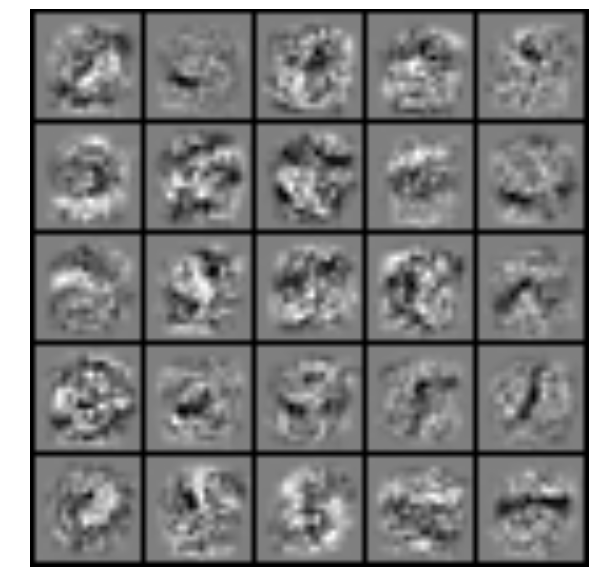

In [142]:
_, _ = displayData(Theta1[:, 1:])

## Prediction accuracy

Lastly, we use the neural network learned parameters to predict labels. We also report the neural net's accuracy, which should be at least around 95%:

In [ ]:
def predict(Theta1, Theta2, X):
    """Predict the label of an input given a trained neural network
    """
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))

    m = X.shape[0]
    num_labels = Theta2.shape[0]

    p = np.zeros((m,1))
    h1 = sigmoid( np.dot( np.column_stack( ( np.ones((m,1)), X ) ) , Theta1.T ) )
    h2 = sigmoid( np.dot( np.column_stack( ( np.ones((m,1)), h1) ) , Theta2.T ) )
    p = np.argmax(h2, axis=1)

    return p + 1 # offsets python's zero notation

In [143]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:f}'.format( ( np.mean(pred == y)*100 ) ) )

Training Set Accuracy: 99.760000
